# Calculate the TSN intrinsic value

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from ipynb.fs.full.c_Stock_visual_QC import read_data_from_sql          # import function from other .ipynb file
pd.options.mode.chained_assignment = None # not to get SettingWithCopyWarning

import warnings
import statsmodels.api as sm

Connection to SQLite DB successful!
Data has been collected!
Datatype has been updated!
Connection closed!


## To Set Vriables please scroll down...

## Function to use

In [2]:
def calculate_missing_columns(df):
    # derived columns
    df['tot_liab'] = df['tot_ass'] - df['tot_equity']
    df['inc_b_tax'] = df['net_inc'] + df['inc_tax_exp']
    df['ebitda'] = df['rev'] - df['cost_sale'] - df['sale_gen_adm']
    df['ebit'] = df['ebitda'] - df['depr_amort']
    df['nopat'] = df['ebit'] - df['inc_tax_exp']
    df['other_curr_ass_lesscash'] = df['acc_rec'] + df['invent'] + df['other_curr_ass']
    df['tot_curr_liab_lessdebt'] = df['tot_curr_liab'] - df['short_debt']
    df['nwc'] = df['other_curr_ass_lesscash'] - df['tot_curr_liab_lessdebt']
    # capex calculation
    capex = []
    for index in range(len(df)):
        if index > 0:
            ppe_change = df['ppe_net'].iloc[index] - df['ppe_net'].iloc[index-1]
            depr_amort = df['depr_amort'].iloc[index]
            capex.append(ppe_change + depr_amort)
        else:
            capex.append(np.nan)
    df.loc[:, 'capex'] = capex

    return df

In [3]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    from statsmodels.tsa.arima.model import ARIMA
    from sklearn.metrics import mean_squared_error
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    print(error)
    return error

In [4]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order, mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg

In [5]:
# create a function to calculate ratios
def calculate_is_margins(df):
    is_incomes = ['cost_sale', 'sale_gen_adm']
    calc_margins = dict()
    # plot and calculate ratios
    for income in is_incomes:
        if income != 'inc_tax_exp':
            div = 'rev'
        else:
            div = 'inc_b_tax'

        fig, ax1 = plt.subplots(figsize=(15, 6))

        ax1.plot(df['end'], df[income]/df[div], label=income.replace('_', ' ').upper())
        ax1.axhline(y=(df[income]/df[div]).mean(), color='r', label='Average value')
        
        ax1.set_xlabel('Date')
        ax1.set_ylabel(income.replace('_', ' ').upper())
        
        plt.legend()
        plt.show()

        calc_margins[income+'_margin'] = (df[income]/df[div]).mean()

        print(str(income)+' is divided by the revenue.')
        print('Average value: '+str((df[income]/df[div]).mean()))

    return calc_margins

In [6]:
def predict_cos_sale_gen_adm(input_df, is_ratio_dictionary):
    # predict Cost Of Sales & Sale, General Administration from the Revenue
    for column in ['cost_sale', 'sale_gen_adm']:
        input_df[column] = input_df['rev'] * is_ratio_dictionary[column+'_margin']

    return input_df

In [7]:
def fixed_asset_ratios(df):
    # calculate PPE start & CAPEX
    df['ppe_net_start'] = [df['ppe_net'].values[i-1] if i > 0 else np.nan for i in range(len(df['ppe_net'].values))]
    df['capex'] = df['ppe_net'] - df['ppe_net_start'] + df['depr_amort']
    
    #calculate ratio
    fixed_asset_ratios = dict()
    # D&A ratio
    for column in ['depr_amort', 'capex']:
        ratio = df[column]/df['ppe_net_start']
        ratio.hist()
        plt.show()
        fixed_asset_ratios[column+'_ratio'] = ratio.mean()
        print('Average', column, 'value is', fixed_asset_ratios[column+'_ratio'])
    return fixed_asset_ratios

In [8]:
def predict_fixed_assets(raw_df, prediction_df, fxd_ass_ratios):
    # get the last measured PPE as start in case of prediction
    ppe_start_pred = [raw_df['ppe_net'].iloc[-1]]
    depr_amort_pred = []
    capex_pred = []
    ppe_net = []
    # calculate prediction
    for index in range(len(prediction_df)):
        depr_amort_pred.append(ppe_start_pred[-1] * fxd_ass_ratios['depr_amort_ratio'])
        capex_pred.append(ppe_start_pred[-1] * fxd_ass_ratios['capex_ratio'])
        ppe_net.append(ppe_start_pred[-1] - depr_amort_pred[-1] + capex_pred[-1])
        # add the last PPE as starting to the PPE start
        ppe_start_pred.append(ppe_net[-1])
    
    prediction_df['depr_amort'] = depr_amort_pred
    prediction_df['capex'] = capex_pred
    prediction_df['ppe_net'] = ppe_net

    return prediction_df

In [9]:
def calc_eff_tax_rate(df):
    if df['end'].iloc[-1] > pd.Timestamp('2017-01-01'):
        eff_tax_rate = 0.21
    else:
        eff_tax_rate = (df['inc_tax_exp']/df['ebit']).mean()
        # plot
        (df['inc_tax_exp']/df['ebit']).hist(range=[0, 1])
        plt.show()

    print('Effective tax rate is', eff_tax_rate)
    return eff_tax_rate

In [10]:
def calculate_ebitda_ebit_nopat(prediction_df, eff_tax_rate):
    prediction_df['ebitda'] = prediction_df['rev'] - prediction_df['cost_sale'] - prediction_df['sale_gen_adm']
    prediction_df['ebit'] = prediction_df['ebitda'] - prediction_df['depr_amort']
    prediction_df['nopat'] = prediction_df['ebit'] - (prediction_df['ebit'] * eff_tax_rate)
    return prediction_df

In [11]:
def plot_hist_pred(hist_df, pred_df):
    # reset index
    pred_df.index = [i for i in range(len(hist_df), len(hist_df) + len(pred_df))]
    
    for column in pred_df.columns:
        try:
            fig, ax1 = plt.subplots(figsize=(15, 6))

            ax1.plot(hist_df.index, hist_df[column], color='k', label='Historical data')
            ax1.plot(pred_df.index, pred_df[column], color='r', label='Predicted values')

            ax1.set_xlabel('Index')
            ax1.set_ylabel(column.replace('_', ' ').upper())

            plt.legend()
            plt.show()
        except:
            continue

In [12]:
def calculate_nwc_ratios(df):
    result = dict()
    # Days Sales Outstanding (dso)
    dso = (df['acc_rec'] / df['rev']) * 360
    dso.hist()
    plt.show()
    result['dso'] = dso.mean()
    print('DSO:', result['dso'])

    #Days Inventory Out. (dis)
    dio = (df['invent'] / df['cost_sale']) * 360
    dio.hist()
    plt.show()
    result['dio'] = dio.mean()
    print('DIO:', result['dio'])

    #Days Payable Out. (dpo)
    dpo = (df['acc_pay'] / df['cost_sale']) * 360
    dpo.hist()
    plt.show()
    result['dpo'] = dpo.mean()
    print('DPO:', result['dpo'])


    #Sum of Other current assets per revenue --> soca_rev
    # calculate the non cach non accoint recivable and inventory total current assets ratio to revenue
    soca_rev = (df['tot_curr_ass'] - df['acc_rec'] - df['invent'] - df['cash_cash_eq']) / df['rev']
    soca_rev.hist()
    plt.show()
    result['soca_rev'] = soca_rev.mean()
    print('Sum Other Current Assets:', result['soca_rev'])

    #Sum of Other current liabilities per revenue --> socl_rev
    # calculate the non current debt non account payable total current liabilities ratio to revenue
    socl_rev = (df['tot_curr_liab'] - df['short_debt'] - df['acc_pay']) / df['rev']
    socl_rev.hist()
    plt.show()
    result['socl_rev'] = socl_rev.mean()
    print('Sum Other Current Liabilities per Rec', result['socl_rev'])
    
    return result

In [13]:
def predict_curr_ass_liab(df_prediction, nwc_ratios):
    # calculate assets, liabilities, and net working capital from NWC ratio
    df_prediction['acc_rec'] = (df_prediction['rev'] * nwc_ratios['dso']) / 360
    df_prediction['invent'] = (df_prediction['cost_sale'] * nwc_ratios['dio']) / 360
    df_prediction['acc_pay'] = (df_prediction['cost_sale'] * nwc_ratios['dpo']) / 360
    
    df_prediction['other_curr_ass_lesscash'] = df_prediction['acc_rec'] + df_prediction['invent'] + (df_prediction['rev'] * nwc_ratios['soca_rev'])
    df_prediction['tot_curr_liab_lessdebt'] = df_prediction['acc_pay'] + (df_prediction['rev'] * nwc_ratios['socl_rev'])
    df_prediction['nwc'] = df_prediction['other_curr_ass_lesscash'] - df_prediction['tot_curr_liab_lessdebt']
    return df_prediction

In [14]:
def calc_change_nwc(df_hist, df_predict):
    c_nwc = []
    # check the 2 DataFrame is equal & calculate NWC for measured data
    if df_hist.equals(df_predict):
        for index in range(len(df_predict)):
            if index > 0:
                c_nwc.append(df_predict['nwc'].iloc[index] - df_predict['nwc'].iloc[index-1])
            else:
                c_nwc.append(np.nan)
    # calculate NWC for future data
    else:
        for index in range(len(df_predict)):
            if index > 0:
                c_nwc.append(df_predict['nwc'].iloc[index] - df_predict['nwc'].iloc[index-1])
            else:
                c_nwc.append(df_predict['nwc'].iloc[index] - df_hist['nwc'].iloc[-1])
    
    df_predict['c_nwc'] = c_nwc
    
    return df_predict

In [15]:
def calc_unleveared_fcf(df):
    df['unlev_fcf'] = df['nopat'] + df['depr_amort'] - df['capex'] - df['c_nwc']
    return df

In [16]:
def calculate_wacc(df, share_price, eff_tax_rate, us_bond_10_yr, equity_risk_premium, beta):
    equity = (share_price * df['shares'].iloc[-1])
    debt = df['short_debt'].iloc[-1] + df['tot_long_debt'].iloc[-1]
    
    cost_of_debt = abs(df['int_exp'].iloc[-1]) / debt
    d_per_d_plus_e = debt / (debt + equity)
    after_tax_cost_of_debt = cost_of_debt * (1 - eff_tax_rate)

    risk_free_rate = us_bond_10_yr
    market_risk_premium = equity_risk_premium
    cost_of_equity = risk_free_rate + (beta * market_risk_premium)
    e_per_d_plus_e = equity / (debt + equity)
    
    wacc = (d_per_d_plus_e * after_tax_cost_of_debt) + (e_per_d_plus_e * cost_of_equity)
    return wacc

In [17]:
def calculate_present_value_fcf(df, wacc, report='10-Q'):
    if report == '10-Q':
        multipl = 0.25
    else:
        multipl = 1
    # calculate present cahs flows
    df['pres_val_fcf'] = df['unlev_fcf']/((1+wacc)**(df.index*multipl))
    return df

In [18]:
def calculate_tv_prestv_enterp_val(df, industry_growth_rate, wacc):
    # Terminal Value
    tv = ((df['unlev_fcf'].iloc[-1] * (1 + industry_growth_rate))) / (wacc - industry_growth_rate)
    # present value of TV
    pres_value_tv = tv / (1 + wacc)**5
    
    return tv, pres_value_tv

In [19]:
def calc_enterp_company_value(df_hist, df_pred, pres_value_tv):
    
    debt = df_hist['short_debt'].iloc[-1] + df_hist['tot_long_debt'].iloc[-1]
    
    if 'equity_minor_interest' in df_hist.columns:
        equity_minor_interest = df_hist['equity_minor_interest'].iloc[-1]
    else:
        equity_minor_interest = 0
    # Enterprise Values
    enterp_val = df_pred['pres_val_fcf'].sum() + pres_value_tv
    # Company Value
    comp_val = enterp_val + df_hist['cash_cash_eq'].iloc[-1] - debt - equity_minor_interest
    

    print(enterp_val, comp_val)
    return enterp_val, comp_val

In [20]:
def implied_share_price(equity_value, hist_df):
    share_price = equity_value / hist_df['shares'].iloc[-1]
    return share_price

## 1. Set boundary parameters (stock price, prediction period, bond yield) & Load Data

In [21]:
# fixed parameters
db_path = '../database/statements.db'
form = '10-Q'
# end date years ago
finished_years_ago = 0
# forecast period
forecast_period = 20
# WACC input
share_price = 108
us_bond_10_yr = 0.0436
# country specifc - USA data from https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/ctryprem.html - 5.5% 10+ yrs average
equity_risk_premium = 0.055
beta = 0.67
# country industry growth rate - US GDP growth avg from 1948 yo 2023 - 3.12%
industry_growth_rate = 0.0312

In [22]:
#load data
data = read_data_from_sql(
    db_path=db_path,
    tickers=['BG'],
    statements=['income_statement', 'balance_sheet']    
)
print('Data are available from:', data['end'].iloc[0])
# start date 7 year earlier than end date
start_date = pd.Timestamp(datetime.date.today()) - (pd.Timedelta(days=(10 * 365) + (finished_years_ago * 365)))
end_date = pd.Timestamp(datetime.date.today()) - (pd.Timedelta(days=finished_years_ago * 365))
# create DataFrame
data_filt = data.loc[(data['form'] == form) & (data['end'] > start_date) & (data['end'] < end_date), :]
data_filt.reset_index(drop=True, inplace=True)
print('Filtered data start at:', data_filt.end.iloc[0])
print('Filtered data finish at:', data_filt.end.iloc[-1])

Connection to SQLite DB successful!
Data has been collected!
Datatype has been updated!
Connection closed!
Data are available from: 2016-09-30 00:00:00
Filtered data start at: 2016-09-30 00:00:00
Filtered data finish at: 2023-06-30 00:00:00


In [23]:
data_filt.head()

,cik,ticker,end,form,rev,cost_sale,sale_gen_adm,inpairm,op_income,int_income,...,intang_ass,other_ass,tot_ass,short_debt,acc_pay,other_curr_liab,tot_curr_liab,tot_long_debt,other_liab,tot_equity
0,0001144519,BG,2016-09-30,10-Q,1.561600e+10,1.086700e+10,324000000.0,0.0,170000000.0,13000000.0,...,318000000.0,8.990000e+08,2.004500e+10,863000000.0,3.205000e+09,3.121000e+09,8.281000e+09,3.447000e+09,826000000.0,7.083000e+09
1,0001144519,BG,2016-12-31,10-Q,1.561600e+10,1.086700e+10,324000000.0,0.0,170000000.0,13000000.0,...,336000000.0,9.270000e+08,1.918800e+10,938000000.0,3.485000e+09,2.476000e+09,7.684000e+09,3.069000e+09,853000000.0,7.144000e+09
2,0001144519,BG,2017-03-31,10-Q,1.112100e+10,1.066100e+10,378000000.0,0.0,82000000.0,12000000.0,...,365000000.0,1.001000e+09,2.062000e+10,938000000.0,3.898000e+09,2.787000e+09,8.616000e+09,3.266000e+09,889000000.0,7.428000e+09
3,0001144519,BG,2017-06-30,10-Q,1.164500e+10,1.129000e+10,328000000.0,0.0,26000000.0,8000000.0,...,362000000.0,9.420000e+08,2.043300e+10,206000000.0,3.513000e+09,2.529000e+09,7.933000e+09,3.918000e+09,879000000.0,7.227000e+09
4,0001144519,BG,2017-09-30,10-Q,1.142300e+10,1.093400e+10,339000000.0,0.0,121000000.0,9000000.0,...,338000000.0,1.015000e+09,2.055200e+10,287000000.0,3.650000e+09,2.197000e+09,7.468000e+09,4.246000e+09,842000000.0,7.546000e+09


## 2. Calculate EBITDA, EBIT, NOPAT, CAPEX etc on hisorical data

In [24]:
data_filt = calculate_missing_columns(data_filt)
data_filt.head()

,cik,ticker,end,form,rev,cost_sale,sale_gen_adm,inpairm,op_income,int_income,...,tot_equity,tot_liab,inc_b_tax,ebitda,ebit,nopat,other_curr_ass_lesscash,tot_curr_liab_lessdebt,nwc,capex
0,0001144519,BG,2016-09-30,10-Q,1.561600e+10,1.086700e+10,324000000.0,0.0,170000000.0,13000000.0,...,7.083000e+09,1.296200e+10,163000000.0,4.425000e+09,4.276000e+09,4.231000e+09,1.146500e+10,7.418000e+09,4.047000e+09,NaN
1,0001144519,BG,2016-12-31,10-Q,1.561600e+10,1.086700e+10,324000000.0,0.0,170000000.0,13000000.0,...,7.144000e+09,1.204400e+10,316000000.0,4.425000e+09,4.276000e+09,4.231000e+09,1.009400e+10,6.746000e+09,3.348000e+09,79000000.0
2,0001144519,BG,2017-03-31,10-Q,1.112100e+10,1.066100e+10,378000000.0,0.0,82000000.0,12000000.0,...,7.428000e+09,1.319200e+10,75000000.0,8.200000e+07,-4.800000e+07,-7.600000e+07,1.130600e+10,7.678000e+09,3.628000e+09,382000000.0
3,0001144519,BG,2017-06-30,10-Q,1.164500e+10,1.129000e+10,328000000.0,0.0,26000000.0,8000000.0,...,7.227000e+09,1.320600e+10,26000000.0,2.700000e+07,-1.250000e+08,-7.000000e+07,1.133900e+10,7.727000e+09,3.612000e+09,132000000.0
4,0001144519,BG,2017-09-30,10-Q,1.142300e+10,1.093400e+10,339000000.0,0.0,121000000.0,9000000.0,...,7.546000e+09,1.300600e+10,121000000.0,1.500000e+08,-1.600000e+07,-4.500000e+07,1.159600e+10,7.181000e+09,4.415000e+09,255000000.0


## 3. Forecast Revenue

Before the ARIMA / SARIMA modling need to know p, d, q values (model parameters):
- p: Trend autoregression order.
- q: Trend moving average order.
- d: Trend difference order.

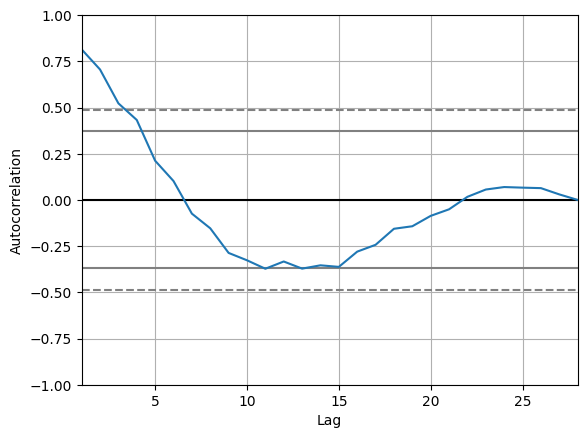

In [25]:
# Creating Autocorrelation plot - ACF
x = pd.plotting.autocorrelation_plot(data_filt['rev'])
x.plot()
plt.show()

The monotony of ACF is changed first time there is the p value. 

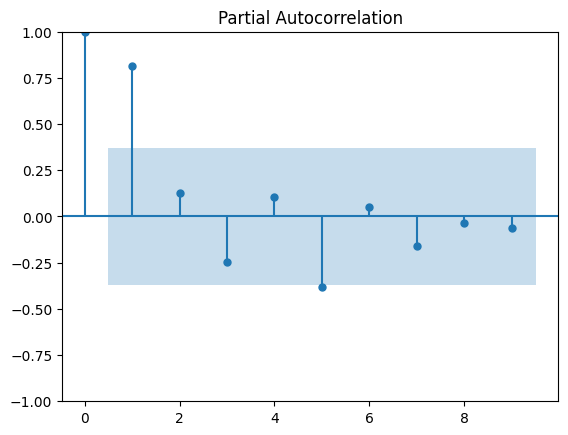

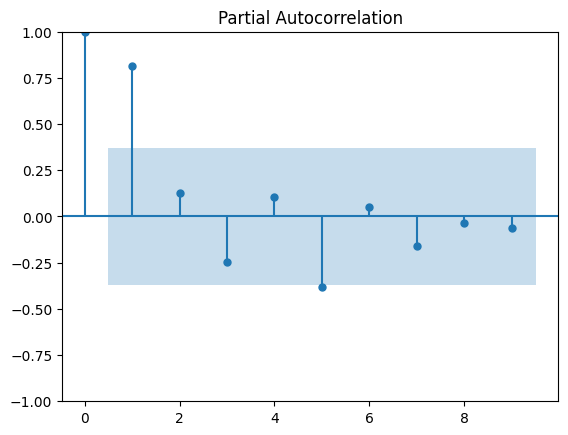

In [26]:
# Creating Partial Autocorrelation plot --> PACF
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data_filt['rev'], lags = int(forecast_period / 2 - 1))

Number of points, which are far away from the boundary is the q value.

In the above partial autocorrelation plot, we can see that only two points are far away from all the points. That is how a decide the q value. Hence the value of q is 2.

The value of d is either 0 or 1. If the data is stationary, we should use 0, and if the data is seasonal, we should use 1. As our data is seasonal, we should use 1 as the d value.

I will find ARIMA hyperparameters (p, d, q) with gridsearch step-by-step

In [27]:
# evaluate an ARIMA model for a given order (p,d,q) ---> You can tip p and estimate d, q based on previous plots
series = data_filt['rev']
# evaluate parameters
p_values = [2, 4]
d_values = [1]
q_values = [1, 3]
warnings.filterwarnings("ignore")
best_config = evaluate_models(series.values, p_values, d_values, q_values)

3.2880959958201103e+18
ARIMA(2, 1, 1) MSE=3288095995820110336.000
3.057530277040274e+18
ARIMA(2, 1, 3) MSE=3057530277040273920.000
3.2401444007571717e+18
ARIMA(4, 1, 1) MSE=3240144400757171712.000
3.2134640676659497e+18
ARIMA(4, 1, 3) MSE=3213464067665949696.000
Best ARIMA(2, 1, 3) MSE=3057530277040273920.000


The predicted values are wrong because the data is seasonal. ARIMA model will never perform well on seasonal time series data. So, here’s how to build a SARIMA model.

The parameter "s" is an integer giving the periodicity (number of periods in season), often it is 4 for quarterly data or 12 for monthly data. Default is no seasonal effect. Here is hardcoded, works well with 12.

In [28]:
# float datatype is needed to SARIMAX model
data_filt['rev'] = data_filt['rev'].astype(float)

In [29]:
# use the model parameters of SARIMA
p, d, q = best_config
model=sm.tsa.statespace.SARIMAX(data_filt['rev'].values,
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90476D+01    |proj g|=  1.37486D+01


 This problem is unconstrained.



At iterate    5    f=  1.19914D+01    |proj g|=  2.07601D-01

At iterate   10    f=  1.19194D+01    |proj g|=  1.17827D-01

At iterate   15    f=  1.18066D+01    |proj g|=  6.63959D-02

At iterate   20    f=  1.18048D+01    |proj g|=  2.31581D-02

At iterate   25    f=  1.18010D+01    |proj g|=  1.38791D-02

At iterate   30    f=  1.17992D+01    |proj g|=  1.66256D-01

At iterate   35    f=  1.17935D+01    |proj g|=  2.58877D-02

At iterate   40    f=  1.17922D+01    |proj g|=  9.77394D-03

At iterate   45    f=  1.17917D+01    |proj g|=  4.47942D-03

At iterate   50    f=  1.17916D+01    |proj g|=  6.69007D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [30]:
# use SARIMAX model
prediction_revenue = model.predict(len(data_filt), len(data_filt) + forecast_period)
# df from results
prediction = pd.DataFrame(
    prediction_revenue,
    index=[i+1 for i in range(len(prediction_revenue))],
    columns=['rev']
)

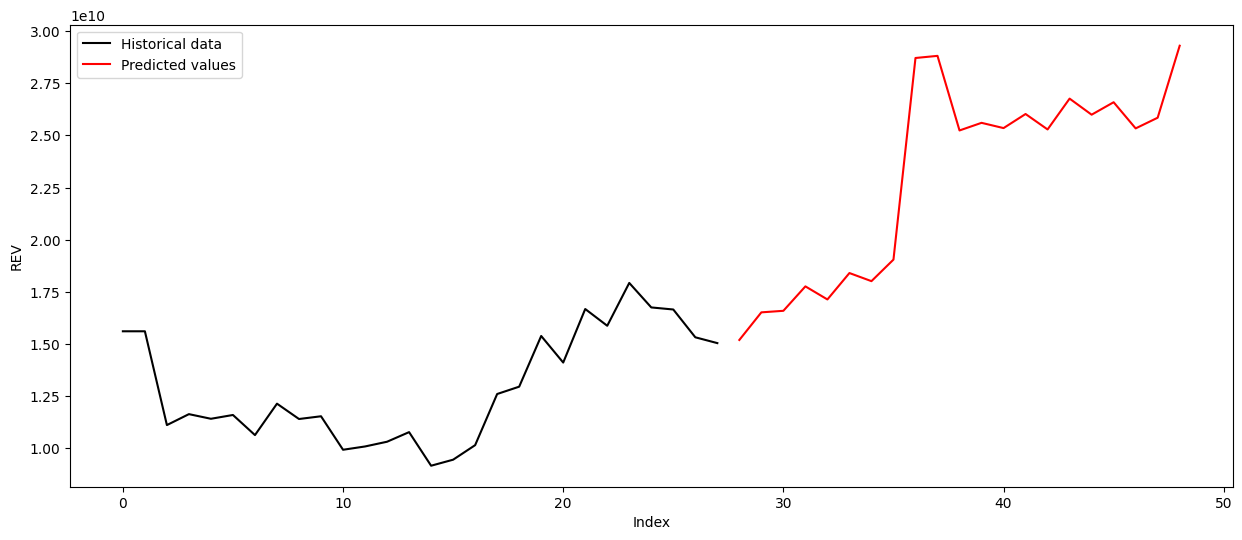

In [31]:
plot_hist_pred(data_filt, prediction)

## 4. Calculate ratios

After the revenue prediction I calculate the expenses and use those to predict future CoS and EBITDA.

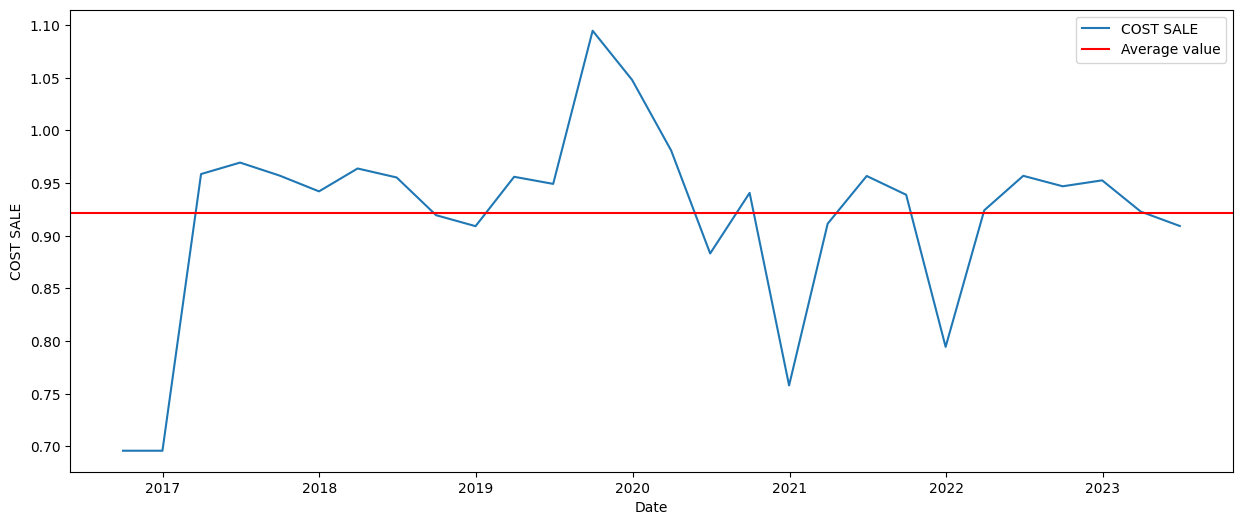

cost_sale is divided by the revenue.
Average value: 0.9211800075737057


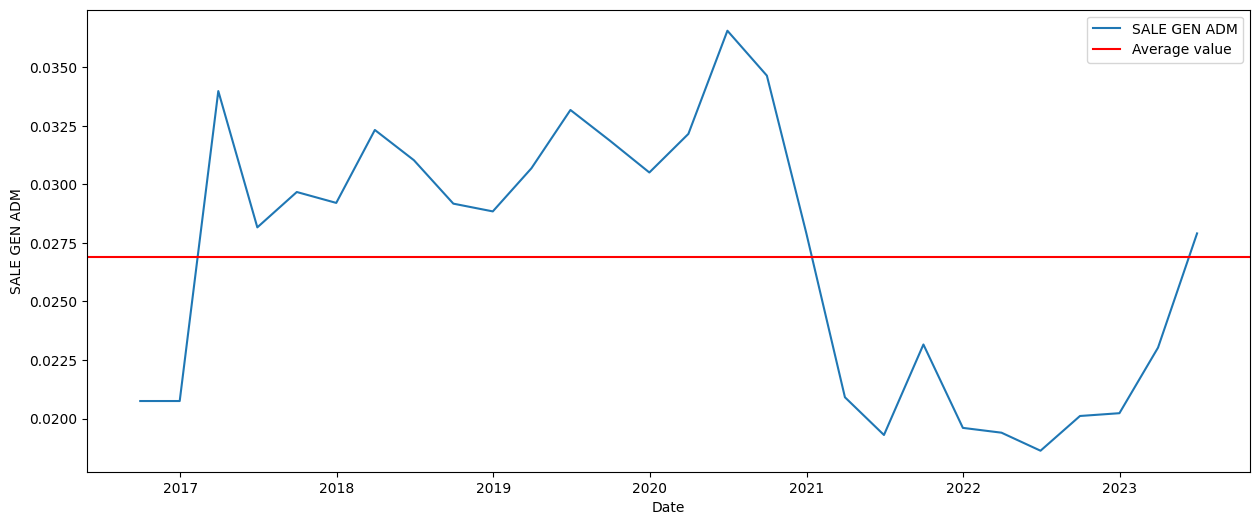

sale_gen_adm is divided by the revenue.
Average value: 0.026919392386060236


In [32]:
is_ratio_dictionary = calculate_is_margins(data_filt)

In [33]:
prediction = predict_cos_sale_gen_adm(prediction, is_ratio_dictionary)
prediction.tail()

,rev,cost_sale,sale_gen_adm
44,2.599595e+10,2.394695e+10,6.997952e+08
45,2.659292e+10,2.449687e+10,7.158653e+08
46,2.533959e+10,2.334232e+10,6.821263e+08
47,2.585110e+10,2.381352e+10,6.958959e+08
48,2.930139e+10,2.699186e+10,7.887757e+08


## 5. Calculate Fixed Assets

It's time to calculate D&A costs.

I will predict the PPE, D&A and CapEx values together.

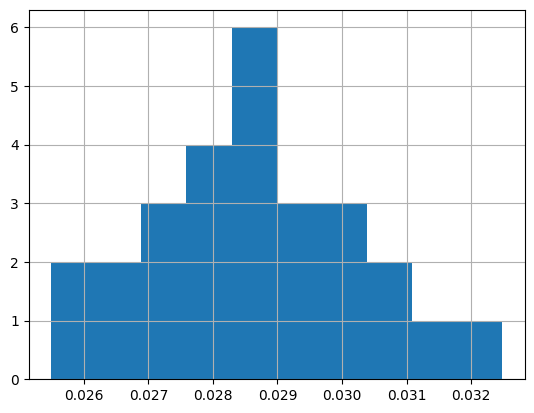

Average depr_amort value is 0.02864378779994392


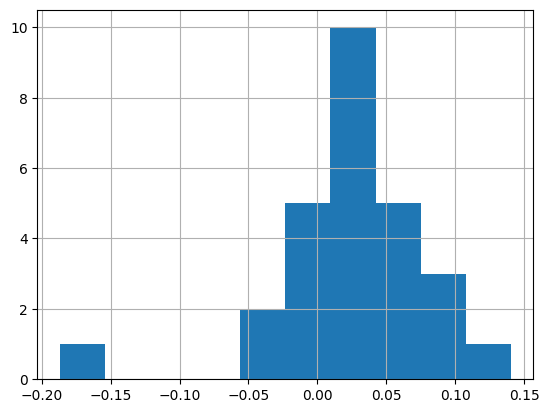

Average capex value is 0.022340203090637


In [34]:
fxd_ass_ratios = fixed_asset_ratios(data_filt)

In [35]:
prediction = predict_fixed_assets(data_filt, prediction, fxd_ass_ratios)
prediction.head()

,rev,cost_sale,sale_gen_adm,depr_amort,capex,ppe_net
28,1.519990e+10,1.400185e+10,4.091722e+08,1.189290e+08,9.275652e+07,4.125828e+09
29,1.652338e+10,1.522101e+10,4.447994e+08,1.181793e+08,9.217182e+07,4.099820e+09
30,1.659721e+10,1.528902e+10,4.467868e+08,1.174344e+08,9.159081e+07,4.073976e+09
31,1.776819e+10,1.636770e+10,4.783088e+08,1.166941e+08,9.101346e+07,4.048296e+09
32,1.714136e+10,1.579028e+10,4.614350e+08,1.159585e+08,9.043975e+07,4.022777e+09


## 6. Calculate EBITDA, EBIT, NOPAT

In [36]:
eff_tax_rate = calc_eff_tax_rate(data_filt)

Effective tax rate is 0.21


In [37]:
prediction = calculate_ebitda_ebit_nopat(prediction, eff_tax_rate)
prediction.head()

,rev,cost_sale,sale_gen_adm,depr_amort,capex,ppe_net,ebitda,ebit,nopat
28,1.519990e+10,1.400185e+10,4.091722e+08,1.189290e+08,9.275652e+07,4.125828e+09,7.888841e+08,6.699551e+08,5.292646e+08
29,1.652338e+10,1.522101e+10,4.447994e+08,1.181793e+08,9.217182e+07,4.099820e+09,8.575735e+08,7.393942e+08,5.841214e+08
30,1.659721e+10,1.528902e+10,4.467868e+08,1.174344e+08,9.159081e+07,4.073976e+09,8.614052e+08,7.439708e+08,5.877369e+08
31,1.776819e+10,1.636770e+10,4.783088e+08,1.166941e+08,9.101346e+07,4.048296e+09,9.221797e+08,8.054855e+08,6.363336e+08
32,1.714136e+10,1.579028e+10,4.614350e+08,1.159585e+08,9.043975e+07,4.022777e+09,8.896469e+08,7.736883e+08,6.112138e+08


## 7. Function to plot Prediction vs Historical data

See at the functions...

## 8. Calculate Net Working Capital

To get this we have to forecast the current assets and liabilities.
I will use ratios to predict them:
- Days Sales Outstanding (dso) --> (Account recivable / Revenue) * 360
- Days Inventory Outstanding (dio) --> (Inventory / Cost of General Sale) * 360
- Other current assets per revenue (oca_rev) --> Other current assets / revenue
- Current liabilities per revenue (tcl_rec) --> (Total current liabilities - current debt) / revenue

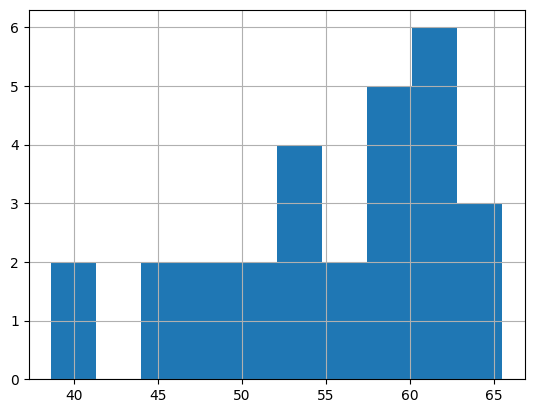

DSO: 55.49742447249474


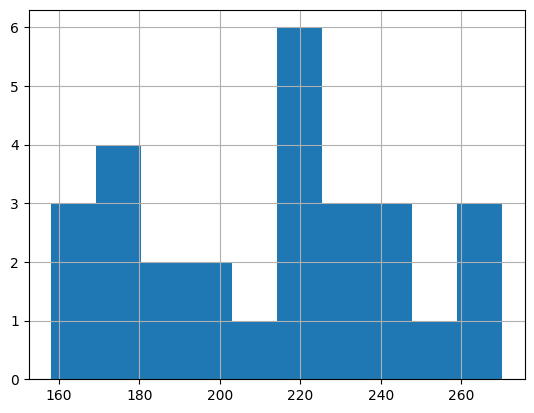

DIO: 212.83637545589178


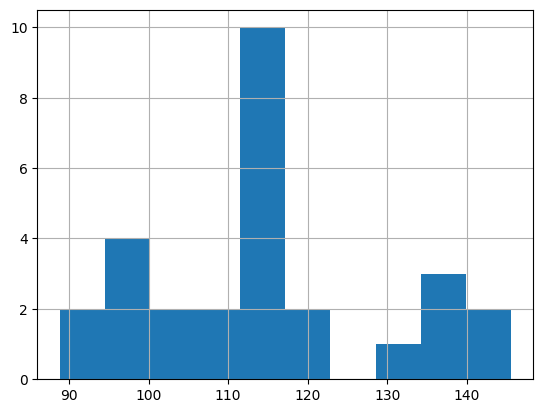

DPO: 114.12577066020756


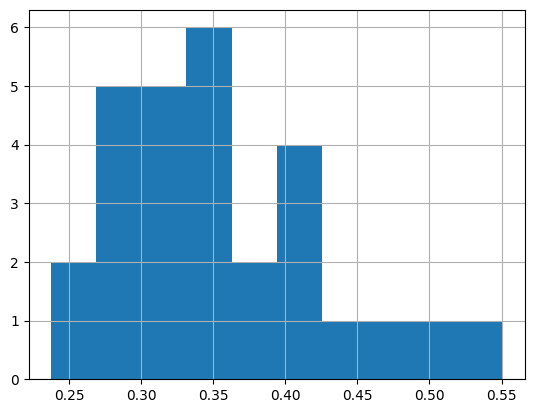

Sum Other Current Assets: 0.3542651677671443


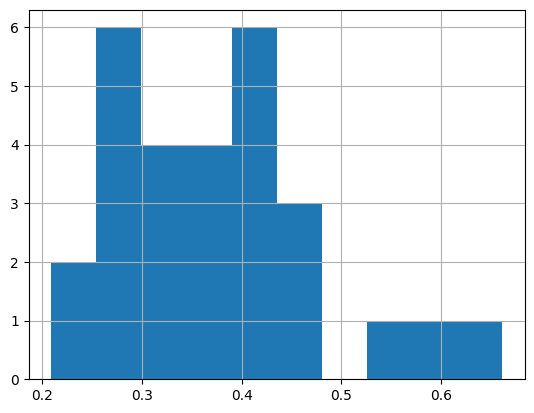

Sum Other Current Liabilities per Rec 0.3760447183206489


In [38]:
nwc_ratios = calculate_nwc_ratios(data_filt)

In [39]:
prediction = predict_curr_ass_liab(prediction, nwc_ratios)
prediction.head()

,rev,cost_sale,sale_gen_adm,depr_amort,capex,ppe_net,ebitda,ebit,nopat,acc_rec,invent,acc_pay,other_curr_ass_lesscash,tot_curr_liab_lessdebt,nwc
28,1.519990e+10,1.400185e+10,4.091722e+08,1.189290e+08,9.275652e+07,4.125828e+09,7.888841e+08,6.699551e+08,5.292646e+08,2.343210e+09,8.278063e+09,4.438810e+09,1.600607e+10,1.015465e+10,5.851415e+09
29,1.652338e+10,1.522101e+10,4.447994e+08,1.181793e+08,9.217182e+07,4.099820e+09,8.575735e+08,7.393942e+08,5.841214e+08,2.547237e+09,8.998846e+09,4.825304e+09,1.739974e+10,1.103884e+10,6.360907e+09
30,1.659721e+10,1.528902e+10,4.467868e+08,1.174344e+08,9.159081e+07,4.073976e+09,8.614052e+08,7.439708e+08,5.877369e+08,2.558618e+09,9.039053e+09,4.846864e+09,1.747748e+10,1.108816e+10,6.389328e+09
31,1.776819e+10,1.636770e+10,4.783088e+08,1.166941e+08,9.101346e+07,4.048296e+09,9.221797e+08,8.054855e+08,6.363336e+08,2.739135e+09,9.676783e+09,5.188823e+09,1.871057e+10,1.187046e+10,6.840112e+09
32,1.714136e+10,1.579028e+10,4.614350e+08,1.159585e+08,9.043975e+07,4.022777e+09,8.896469e+08,7.736883e+08,6.112138e+08,2.642504e+09,9.335404e+09,5.005771e+09,1.805049e+10,1.145169e+10,6.598806e+09


## 9. Change in NWC

In [40]:
prediction = calc_change_nwc(data_filt, prediction)
data_filt = calc_change_nwc(data_filt, data_filt)

In [41]:
prediction = calc_unleveared_fcf(prediction)
data_filt = calc_unleveared_fcf(data_filt)

## 10. Calculate Weighted Average Cost of Capital (WACC)

In [42]:
wacc = calculate_wacc(
    df=data_filt,
    share_price=share_price,
    eff_tax_rate=eff_tax_rate,
    us_bond_10_yr=us_bond_10_yr,
    equity_risk_premium=equity_risk_premium,
    beta=beta)

print('Estimated WACC value:', wacc)

Estimated WACC value: 0.06874113762723322


## 11. Present value of FCF, Terminal Value & present value of TV

In [43]:
prediction = calculate_present_value_fcf(prediction, wacc=wacc, report=form)
prediction.tail()

,rev,cost_sale,sale_gen_adm,depr_amort,capex,ppe_net,ebitda,ebit,nopat,acc_rec,invent,acc_pay,other_curr_ass_lesscash,tot_curr_liab_lessdebt,nwc,c_nwc,unlev_fcf,pres_val_fcf
44,2.599595e+10,2.394695e+10,6.997952e+08,1.074849e+08,8.383088e+07,3.728813e+09,1.349205e+09,1.241721e+09,9.809592e+08,4.007523e+09,1.415773e+10,7.591567e+09,2.737471e+10,1.736721e+10,1.000750e+10,-2.966260e+08,1.301239e+09,6.262668e+08
45,2.659292e+10,2.449687e+10,7.158653e+08,1.068073e+08,8.330245e+07,3.705308e+09,1.380189e+09,1.273381e+09,1.005971e+09,4.099552e+09,1.448285e+10,7.765900e+09,2.800334e+10,1.776603e+10,1.023732e+10,2.298127e+08,7.996634e+08,3.785221e+08
46,2.533959e+10,2.334232e+10,6.821263e+08,1.061341e+08,8.277734e+07,3.681952e+09,1.315140e+09,1.209006e+09,9.551145e+08,3.906338e+09,1.380026e+10,7.399890e+09,2.668353e+10,1.692871e+10,9.754827e+09,-4.824889e+08,1.460960e+09,6.801494e+08
47,2.585110e+10,2.381352e+10,6.958959e+08,1.054650e+08,8.225555e+07,3.658742e+09,1.341688e+09,1.236223e+09,9.766159e+08,3.985193e+09,1.407884e+10,7.549267e+09,2.722218e+10,1.727044e+10,9.951742e+09,1.969147e+08,8.029107e+08,3.676335e+08
48,2.930139e+10,2.699186e+10,7.887757e+08,1.048002e+08,8.173704e+07,3.635679e+09,1.520760e+09,1.415960e+09,1.118608e+09,4.517089e+09,1.595792e+10,8.556852e+09,3.085547e+10,1.957549e+10,1.127998e+10,1.328239e+09,-1.865673e+08,-8.401661e+07


## 12. Terminal Value and present value of TV

I use the perpetuity growth model

In [44]:
tv, pres_value_tv = calculate_tv_prestv_enterp_val(prediction, industry_growth_rate, wacc)
pres_value_tv

-3675431455.7726107

In [45]:
enterp_val, equity_value = calc_enterp_company_value(data_filt, prediction, pres_value_tv)

4176411561.5543833 1224411561.5543833


In [46]:
# adjusted with debt, cash, equity in minor interest
fcst_share_price_adjusted = implied_share_price(equity_value, data_filt)
print('Current adjusted share price:', fcst_share_price_adjusted)

Current adjusted share price: 8.045842797192078


In [47]:
fcst_share_price = implied_share_price(enterp_val, data_filt)
print('Current share price (not adjusted):', fcst_share_price)

Current share price (not adjusted): 27.44399998802981


In [48]:
#plot_hist_pred(data_filt, prediction)